In [ ]:
def factorial(n):
    if n == 0:
        return 1
        lif n < 0:
        return "Factorial not defined for negative numbers."
    else:
        return (n-1)


In [27]:
"""ANOMALY DETECTION SETUP"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('raw-data.csv')
df['time'] = pd.to_datetime(df['ts'],unit='ms')
df.set_index('time', inplace=True)
df.drop(columns=['ts'], inplace=True)

In [33]:
"""TEST LOWER 5 OF CSV"""
df.tail(5)

,id,value,label
time,,,
2020-04-23 13:19:38.000,pump-2,43.276667,1
2020-04-23 13:19:39.617,pump-1,15.709151,0
2020-04-23 13:19:42.999,pump-2,16.214949,0
2020-04-23 13:19:44.617,pump-1,15.393048,0
2020-04-23 13:19:47.999,pump-2,14.855999,0


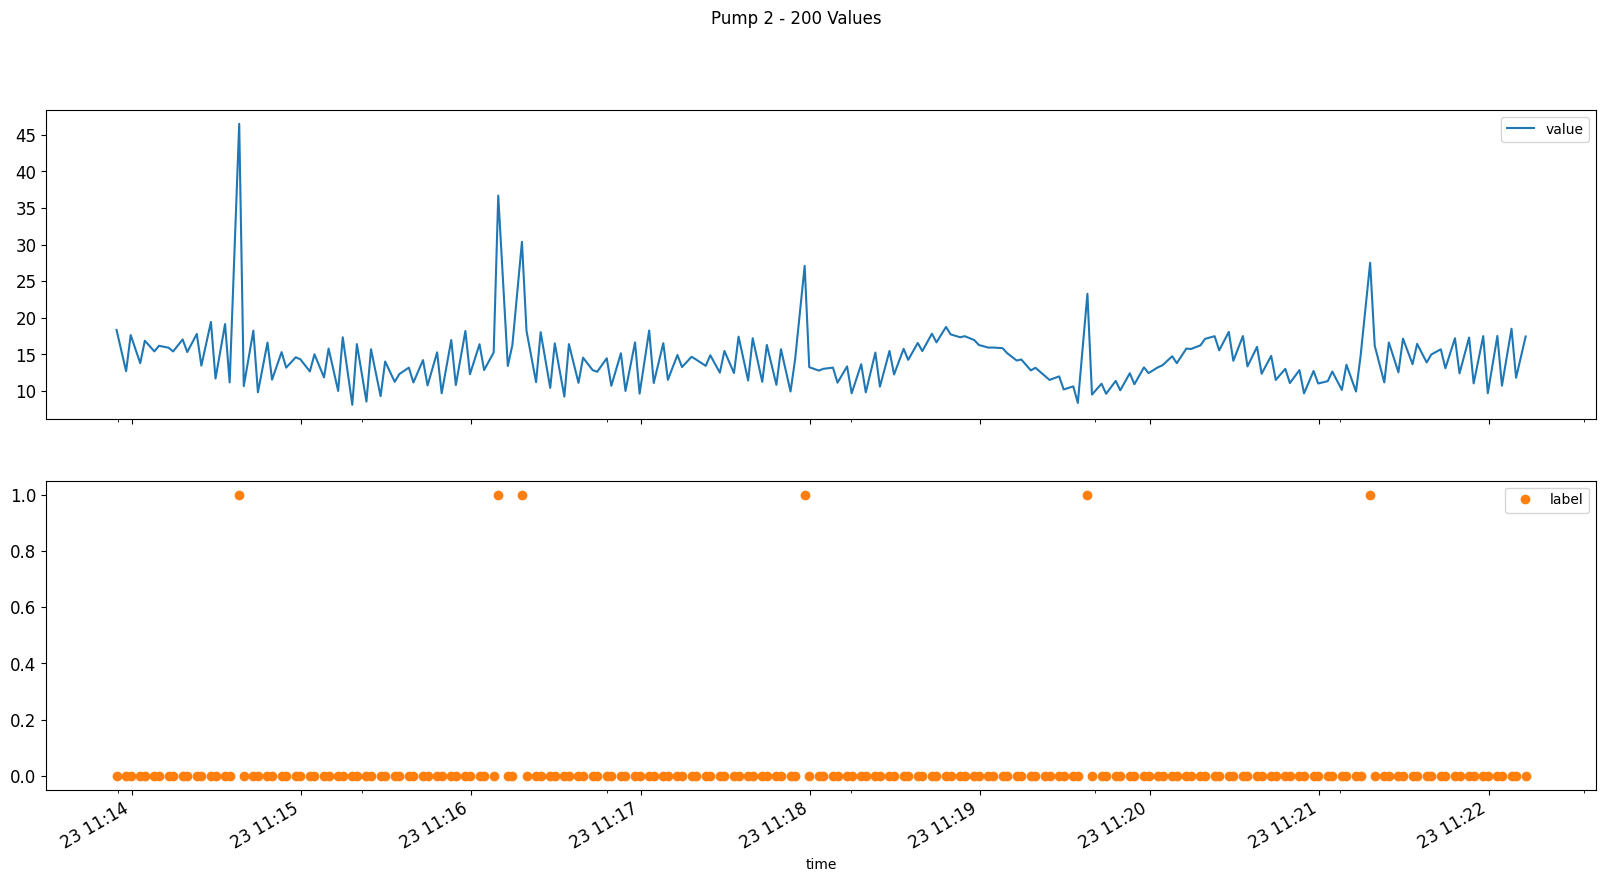

In [37]:
"""VIBRATION DATA/ANOMALY DATA - - Display test, model should detect these"""
df21 = df.head(200)
df21.plot(figsize = (20,10), fontsize = 12, subplots = True, style = ["-", "o"], title = "Pump 2 - 200 Values")
plt.show()

In [6]:
"""DATA WRANGLING -- converting raw time series data into small episodes that can be used for supervised learning (helper functions)"""
# Get list with column names: F1, F2, Fn, L
def get_columns(n):
    f = []
    for x in range(1, n+1):
        f.append("F"+str(x))
    f.append("L")
    return f
    
#Create empty data frame
def create_empty_df(n):
    d = ([0.] * n)
    d.append(0)
    dfx = pd.DataFrame([d], columns = get_columns(n))
    dfx.drop(dfx.index[0], inplace = True)
    return dfx
    
#Create data frame with one row
def create_df(vals: list, label: int = 0):
    if not isinstance(vals, list):
        raise TypeError
    #vals.append(label)
    dfx = pd.DataFrame([vals + [label]], columns = get_columns(len(vals)))
    return dfx

In [7]:
"""CONVERT TIME SERIES DATA INTO EPISODES"""
length = 5
df_epis = create_empty_df(length)
for id in df.id.unique():
    print("Convert data for: ", id)
    df2 = df.loc[df['id'] == id]
    epi = []
    ano = []
    for index, row in df2.iterrows():
        epi.append(row['value'])
        ano.append(row['label'])
        if len(epi) == length:
            l_anomaly = 0
            for i in range(len(ano)):
                if ano[i] == 1:
                    l_anomaly = 1
                    break
            df_row = create_df(epi,l_anomaly) 
            df_epis = pd.concat([df_epis, df_row], ignore_index=True)
            del(epi[0]) 
            del(ano[0])      

Convert data for:  pump-1
Convert data for:  pump-2


In [8]:
"""TEST - DISPLAY EPISODES"""
df_epis.tail(10)

,F1,F2,F3,F4,F5,L
3004,9.025419,9.431438,10.135468,12.042551,12.123937,0
3005,9.431438,10.135468,12.042551,12.123937,12.804910,0
3006,10.135468,12.042551,12.123937,12.804910,14.626118,0
3007,12.042551,12.123937,12.804910,14.626118,14.697982,0
3008,12.123937,12.804910,14.626118,14.697982,16.386558,0
3009,12.804910,14.626118,14.697982,16.386558,17.361092,0
3010,14.626118,14.697982,16.386558,17.361092,18.764962,0
3011,14.697982,16.386558,17.361092,18.764962,43.276667,1
3012,16.386558,17.361092,18.764962,43.276667,16.214949,1
3013,17.361092,18.764962,43.276667,16.214949,14.855999,1


In [9]:
"""EXTRACT FEATURE COLUMNS -- sklern requires seperated feature (X) and target (Y) columns"""
#Extract feature columns
feature_cols = list(df_epis.columns[:-1])

#Extract target column 'label'
target_col = df_epis.columns[-1]

#Show the list of columns
print("Feature columns: \n{}".format(feature_cols))
print("\nTarget column: {}".format(target_col))

#Seperate the data into feature data and target data (X_all and Y_all)
X_all = df_epis[feature_cols]
Y_all = df_epis[target_col]

#Show the feature information by printing the first five rows
print("\nFeature Values:")
print(X_all.head())

Feature columns: 
['F1', 'F2', 'F3', 'F4', 'F5']

Target column: L

Feature Values:
          F1         F2         F3         F4         F5
0  18.340181  17.647661  16.874933  16.180807  15.407113
1  17.647661  16.874933  16.180807  15.407113  15.324012
2  16.874933  16.180807  15.407113  15.324012  13.470387
3  16.180807  15.407113  15.324012  13.470387  11.702384
4  15.407113  15.324012  13.470387  11.702384  11.176102


In [10]:
"""TRAINING AND TESTING DATA SETS -- split into 67% for training set and 33% for testing set"""
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 42)

#Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))
print("Anomaly rate of the training set: {:.2f}%".format(100 * (y_train == 1).mean()))
print("Anomaly rate of the testing set: {:.2f}%".format(100 * (y_test == 1).mean()))

Training set has 2019 samples.
Testing set has 995 samples.
Anomaly rate of the training set: 14.46%
Anomaly rate of the testing set: 12.66%


In [11]:
"""MODEL TRAINING using Decision Tree -- model that predicts the value of a target variable by learning simple decison rules inferred from data features"""
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

my_random_seed = 42

#Initialize the DecisionTreeClassifier
model = DecisionTreeClassifier(random_state = my_random_seed)

#Train the classifier
model.fit(X_train.values, y_train.values)

#Predict with the test data
y_predict = model.predict(X_test.values)

#Determine the accuracy score
accuracy_score = accuracy_score(y_test, y_predict)

print("Accuracy score for the trained model: {:.4f}.".format(accuracy_score))

Accuracy score for the trained model: 0.9970.


In [12]:
"""SAVE MODEL, VALIDATE WORKING"""
from joblib import dump, load

filename = 'model.joblib'
dump(model, open(filename, 'wb'))


loaded_model = load(open(filename, 'rb'))
result = loaded_model.score(X_test.values, y_test.values)
print("Score:", result)

Score: 0.9969849246231156


In [13]:
"""SETUP INFERENCE ON REAL TIME DATA"""
import os, sys
class AnomalyDetection(object):
    def __init__(self):
        print("Initializing...")
        self.model_file = os.environ.get('MODEL_FILE', 'model.joblib')
        print("Load modelfile: %s" % (self.model_file))
        self.clf = load(open(self.model_file, 'rb'))

    def predict(self, X, feature_names):
        print("Predict features: ", X)
        print("Prediction: ", prediction)
        return prediction

In [6]:
"""TESTING - predict anomalies for a list of values"""
p = AnomalyDetection()

X = np.asarray([[96.1, 15.40, 15.32, 13.47, 17.70]], dtype=np.float32)
print("Features types: ", type(X), type(X[0][0]))
print("Predict features: ", X)
prediction = p.clf.predict(X)
print("Prediction: ", prediction)

NameError: name 'AnomalyDetection' is not defined